# Parametric Survival Anlaysis

### Introduction

As we learned in the non-parametric analysis, sometimes we need to extrapolate or interpolate estimations of reliability. Non-parametric models are not always suited to this. As such we need another method to model reliability.

Before diving explicity into the distribution most commonly used in survival analysis, we will dive into an experiment. In this experiment we are going to find the strength of a chain.

It is quite obvious that the strength of a chain to bear a load is equal to the strength of the weakest link. This is true of many other scenarios, the strength of cotton fibres is only as much as the weakest strand in the fibre, survival times, strength of structures. All these depend on the minimum strength to determine the strength/duration of the object/person. Any way to model this behaviour would be extremely (hint) useful.

Let's start with a chain. Let's say we are trying to estimate the strength of a chain for some application. We have 100 test chains. Each chain has 1000 links, the distribution of chain link strength is normal with mean 200 and std dev of 10. Some simple monte carlo modelling can show us what we might expect:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
EPS = np.sqrt(np.finfo(np.float64).eps)

In [4]:
import parametric as par

In [5]:
dist = par.Weibull
x = np.array([16, 34, 53, 75, 93, 120])
n = None
c = None

In [6]:
model = dist.fit(x, how='MLE')
print(model.params)
model.res

(73.52616393416096, 1.9326856780632191)


     fun: 29.584921614974103
    hess: array([[ 0.00414562, -0.03221247],
       [-0.03221247,  2.62501825]])
     jac: array([1.24240355e-07, 1.73035866e-05])
 message: 'Optimization terminated successfully.'
    nfev: 1
    nhev: 1
     nit: 0
    njev: 1
  status: 0
 success: True
       x: array([73.52616393,  1.93268568])

In [7]:
model.dist.u(73., *model.params)

-0.01388030428854892

In [16]:
print(model.sf(73.))
a = model.dist.u_cb(np.array([73., 75.]), *model.params, model.hess_inv)

0.372985556363472


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [14]:
a

array([-0.52544871,  0.4976881 ])

In [16]:
from numpy.linalg import inv

In [17]:
inv(model.res.hess)

array([[266.64327792,   3.27206822],
       [  3.27206822,   0.42110237]])

In [21]:
def grad_r(z):
    J = np.matrix(jacobian(lambda x : model.dist.sf(*x))(np.array([z, *model.params]))[1::])
    J = np.matmul(J.T, J)
    out = np.matmul(model.hess_inv, J)
    return out
    

In [30]:
model.sf(1.)  + np.sqrt(grad_r(1.).sum()) * 1.96

1.0045768386535974

In [21]:
model.params

(8.804864891072128, 2.234172684485362)

In [24]:
def var_r(x):
    J = np.matrix(model.jac_r(np.array(x)))
    
    print(J)
    out = np.matmul(model.hess_inv, J)
    return out.sum()

In [25]:
model.hess_inv

array([[-0.85948728, -0.11580176],
       [-0.11580176, -0.16173259]])

In [26]:
var_r(1.)

[[0.00029523]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

In [ ]:
var_r = lambda x : 

In [11]:
from autograd import jacobian, hessian, grad
dist = par.Gumbel
if n is None:
    n = np.ones_like(x).astype(np.int64)

if c is None:
    c = np.zeros_like(x).astype(np.int64)

x_ = np.repeat(x, n)
c_ = np.repeat(c, n).astype(np.int64)
n_ = np.ones_like(x_).astype(np.int64)

init = dist.parameter_initialiser(x_, c_, n_)
fun  = lambda t : dist.neg_ll(x_, c_, n_, *t)
#jac  = lambda t : dist.jacobian(x_, *t, c_, n_)
if True:
    jac = jacobian(fun)
    hess = hessian(fun)
    res = minimize(fun, init, method='trust-exact', jac=jac, hess=hess)
else:
    jac = lambda t : approx_fprime(t, fun, EPS)
    res = minimize(fun, init, method='BFGS', jac=jac)

In [12]:
res.hess

array([[0.00556641, 0.00256011],
       [0.00256011, 0.01067182]])

In [37]:
var_r = model.res.hess_inv

array([[ 0.69121163,  2.90245624],
       [ 2.90245624, 14.63768502]])

In [4]:
#x = par.LogNormal.random(100, 2, 0.4)
model = par.LogNormal.fit(data)
init = model.params
init[0], init[1]

initial MLE:  Normal   (3.515855393064993, 0.8491910032926702)
Final MLE:  Normal   [3.51585539 0.849191  ]
initial MLE:  LogNormal   (3.515855393064993, 0.8491910032926702)
Final MLE:  LogNormal   [3.51585539 0.849191  ]


(3.515855393064993, 0.8491910032926702)

In [5]:
n = 1000
mean = 200
std_dev = 10
links = 1000

chain_strength = np.random.gamma(scale=std_dev, shape=mean, size=(n, links)).min(axis=0)

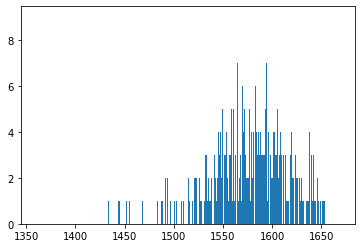

In [7]:
plt.hist(chain_strength, bins=n);

That seems to be quite regularly distributed. What happens if we increase the number of links and the count of chains?


In [8]:
links = 1000
chain_strength = np.random.normal(loc=mean, scale=std_dev, size=(n, links)).min(axis=0)

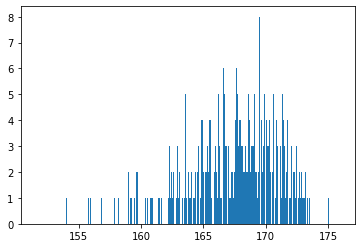

In [9]:
plt.hist(chain_strength, bins=n);

This appears to be quite a regular distribution. If we get some information about this distribution we could know a lot about the strength of these chains.

It turns out, that as the number of chains and links tend to infinity, the distribution converges to the 'Weibull' distribution. This is exactly analagous to the central limit theorem and the normal distribution. That is, as we get more and more samples, the mean of a set of random variables converges to the normal distribution. Whereas here we have shown that that the minimum converges to a Weibull distribution. Neat huh!

But what is the weibull distribution?

$$ F = 1 - e^{-({\frac{x}{\alpha}})^\beta}  $$

The above equation is the CDF for the Weibull distribution. For survival analysis, F is the probability of not surviving till x. Or put another way, it is the probability of dying (failing) before reaching x.

For the equation above, x is the variable, alpha is the 'characteristic life' or scale parameter, and beta is the shape parameter.

Let's use surpyval to fit a distribution.

In [10]:
import parametric as par

In [13]:
#x = np.array([16, 34, 53, 75, 93, 120])
x = par.Weibull.random(100, 45, 55)

initial MLE:  Gumbel   (3.800018466503699, 0.020578027155773553)
Final MLE:  Gumbel   [3.80975072 0.01745806]
initial MLE:  Weibull   (45.12185537240282, 58.697319219860475)
Final MLE:  Weibull   [45.1391855  57.28012761]


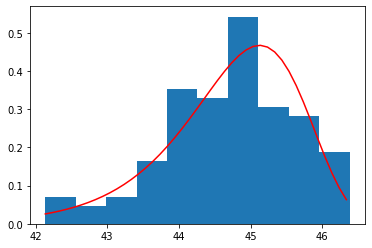

In [14]:
model = par.Weibull.fit(x, how="MLE")
xx = np.arange(np.min(x), np.max(x), 0.1)
y = model.df(xx)
plt.hist(x, density=True)
plt.plot(xx, y, color='r');
model.params;

The above plot shows that the distribution we have made is a remarkable fit to our simulated data. It also turns out the Weibull distribution is one of three distributions as part of 'Extreme Value' statistics. The other distributions are the Gumbel and the Frechet (where the Frechet distribution models the maxmimum!). But this is not important for our survival analysis. 

The important fact for us is that the Weibull distribution is useful for modeling the strength (or reliability) in many scenarios.

But we can see that it is extremely useful when trying to estimate the strength of objects

### Finding Weibull Parameters

The question now is, how do we find the parameters for the Weibull distribution?

The SurPyval package allows users to use several methods, these are:
- Plotting Positions
- Method of Moments
- Maximum Likelihood
- Maximum Spacing Estimation

The examples used for these will be for complete data.

In [15]:
import nonparametric as nonp
import WeibullScale

In [16]:
x = np.array([1, 2, 3, 4, 5, 6, 6, 7])
c = None
n = np.array([2, 3, 4, 4, 5, 6, 7, 1])
c = np.array([0, 1, 0, 0, 1, 0, 1, 0])

In [17]:
a = par.Gumbel.fit(np.log(x), c=c, n=n, how="MPP")

In [18]:
a.params

(1.8510131937896173, 0.6191771855390528)

In [19]:
x, c, n

(array([1, 2, 3, 4, 5, 6, 6, 7]),
 array([0, 1, 0, 0, 1, 0, 1, 0]),
 array([2, 3, 4, 4, 5, 6, 7, 1]))

In [20]:
a = par.Weibull.fit(x, c=c, n=n, how="MLE")

initial MLE:  Gumbel   (2.665002408942492, 0.508906973285325)
Final MLE:  Gumbel   [1.85021202 0.38138223]
initial MLE:  Weibull   (6.3611681041444985, 2.6220414123537013)
Final MLE:  Weibull   [6.3611681  2.62204141]


In [21]:
a.params

(6.3611681041444985, 2.6220414123537013)

In [22]:
x, r, d, R = nonp.nelson_aalen(x, c=c)

0.05 0.9


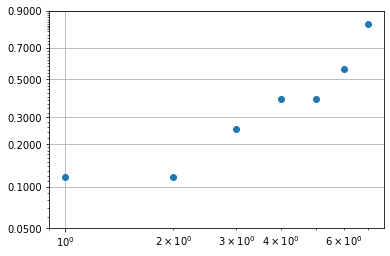

In [23]:
plt.grid(True)
plt.scatter(x, 1 - R)
plt.yscale('weibull')
plt.xscale('log')
ax = plt.gca()
ax.set_axisbelow(True)
ax.set_ylim((0.05, .90));


In [24]:
x = np.array([32, 33, 34, 35, 36, 37, 38, 39, 40, 42]) * 1.275
n = np.array([10, 33, 81, 161, 224, 289, 336, 369, 383, 389])
c = None
# Mr Weibull's measurements are cumulative, so let's calculate the obervations at each point.
n = np.concatenate([[n[0]], np.diff(n)])

In [25]:
#xx = par.Weibull.random(10, 10, 200)
weib_2p = par.Weibull3p.fit(x, n=n, how='MLE')
print(weib_2p.params)
weib_2p.res

initial MLE:  Weibull3p   (6.900793226559274, 2.012291266059257, 39.8)
Final MLE:  Weibull3p   [ 7.14192526  2.62045242 39.76562959]
(7.141925261015744, 2.62045242290675, 39.765629593531784)


      fun: 918.26408828147
 hess_inv: array([[ 0.18491659,  0.07455037, -0.14959126],
       [ 0.07455037,  0.04052067, -0.06375495],
       [-0.14959126, -0.06375495,  0.136033  ]])
      jac: array([2.67094151e-07, 1.04671614e-07, 1.00713251e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([ 7.14192526,  2.62045242, 39.76562959])

In [26]:
from scipy.special import gamma as gamma_func
from scipy.special import gammainc, gammaincinv

In [102]:
jac = np.vectorize(lambda x : approx_fprime(np.array([x]), par.Gamma.neg_ll, eps))

In [103]:
df([1., 2.2, 3., 4.])

array([-0.57721565,  0.59970385,  1.84556869,  7.53670609])

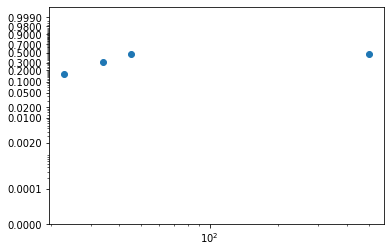

In [20]:
x = np.array([23, 34, 45, 500, 500, 500])
c = np.array([0, 0, 0, 1, 1, 1])

x_, r, d, R = nonp.nelson_aalen(x, c=c)

import WeibullScale

plt.scatter(x_, 1 - R)
plt.yscale('Weibull')
plt.xscale('log')

In [61]:
import pandas as pd

In [62]:
test = pd.DataFrame({'t' : x, 'c' : c})#.to_csv('test.csv', index=False)

In [63]:
test

,t,c
0,23,0
1,34,0
2,45,0
3,500,1
4,500,1
5,500,1


In [64]:
def get_x_r_d(t, c=None, n=None):
    x = t.copy()
    # Handle censoring
    if c is None: c = np.zeros_like(x).astype(np.int64)
    else: c.astype(np.int64, casting='safe')
    assert c.shape == t.shape
    assert not ((c != 1) & (c != 0)).any()
    
    # Handle counts
    if n is not None:
        n = n.astype(np.int64, casting='safe')
        x = np.repeat(x, n)
        c = np.repeat(c, n)
    else:
        n = np.ones_like(x).astype(np.int64)
    assert n.shape == t.shape
    assert (n > 0).all()

    x, idx = np.unique(x, return_inverse=True)
    
    d = np.bincount(idx, weights=1 - c)
    # do is drop outs
    do = np.bincount(idx, weights=c)
    r = n.sum() + d - d.cumsum() + do - do.cumsum()
    r = r.astype(np.int64)
    d = d.astype(np.int64)
    return x, r, d

In [65]:
get_x_r_d(test['t'], c=test['c'])

(array([ 23,  34,  45, 500]), array([6, 5, 4, 3]), array([1, 1, 1, 0]))

In [26]:
test.isna().any().any()

False

In [27]:
model = par.Weibull.fit(x, c=c, how='MPP')

In [28]:
model.params

(57.33363232986079, 1.9536382542712791)

In [29]:
model

In [30]:
import scipy
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

class NonRepairable():

    def __init__(self, distribution):
        self.dist = distribution
        self.cost_rate = np.vectorize(self._cost_rate)

    def set_costs_planned_and_unplanned(self, cp, cu):
        self.cp = cp
        self.cu = cu

    def avg_replacement_time(self, t):
        return quad(self.dist.sf, 0, t)[0]

    def _cost_rate(self, t):
        planned_costs = self.dist.sf(t) * self.cp
        unplanned_costs = (1 - self.dist.sf(t)) * self.cu
        avg_repl_time = self.avg_replacement_time(t)
        print(avg_repl_time)
        return (planned_costs + unplanned_costs) / avg_repl_time

    def find_optimal_replacement(self):
        init = self.dist.mean()
        bounds = ((0, None),)
        res = minimize(self._cost_rate, init, bounds=bounds)
        self.optimisation_results = res
        return res.x[0]

In [31]:
model.params = (1.0432994845255468, 2.1619111027076143)

In [32]:
model.dist.name

'Weibull'

In [33]:
nr = NonRepairable(model)

In [34]:
nr.dist.dist.name

'Weibull'

In [35]:
nr.avg_replacement_time(10)
nr.set_costs_planned_and_unplanned(2, 10)

In [36]:
nr.cost_rate([150, 154, 160])

0.9239497357806958
0.9239497357806958
0.9239497357808334
0.9239497357810543


array([10.82309958, 10.82309958, 10.82309958])

In [37]:
nr.find_optimal_replacement()

0.7424329694346196
0.7424329740693021
0.0
1e-08
0.7424329694346196
0.7424329740693021


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


0.9239497357791123

In [38]:
nr.optimisation_results

      fun: array([8.47518133])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.69556457])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([0.92394974])

In [39]:
cost_curve_x = np.linspace(model.qf(0.01), model.qf(0.99), num=1000)
cost_curve_y = nr.cost_rate(cost_curve_x)

0.12386017776203744
0.12386017776203744
0.12583209040384263
0.12780330340473503
0.12977380417560722
0.1317435801088584
0.13371261857909786
0.13568090694383858
0.1376484325441798
0.13961518270548068
0.14158114473802355
0.1435463059376695
0.14551065358650403
0.14747417495347523
0.149436857295024
0.15139868785570637
0.1533596538688084
0.15531974255695455
0.1572789411327086
0.15923723679916862
0.1611946167505549
0.1631510681727928
0.16510657824408861
0.16706113413550056
0.16901472301150391
0.17096733203055087
0.17291894834562535
0.1748695591047928
0.17681915145174504
0.17876771252634074
0.180715229465141
0.1826616894019408
0.18460707946829608
0.18655138679404676
0.18849459850783523
0.19043670173762217
0.19237768361119667
0.19431753125668466
0.19625623180305188
0.1981937723806049
0.20013014012148733
0.20206532216017384
0.20399930563395993
0.2059320776834493
0.2078636254530373
0.2097939360913922
0.2117229967519324
0.21365079459330188
0.21557731677984165
0.21750255048205938
0.2194264828770952

In [40]:
np.min(cost_curve_y)

7.3947415529819045